In [75]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import create_data, create_design_matrix
from sklearn.model_selection import train_test_split
from src.models import ols_model, ridge_model, lasso_model_skl
from src.utils import statistics
from src.sampling import bootstrap, cross_validation
import numpy as np 


# Part a: Ordinary least square (OLS) on the Franke function

In [87]:
np.random.seed(2021)

N = 100
noise_var = 0.9
num_degrees = 15

mse_test = []
r2_test = []
mse_train = []
r2_train = []

x1, y1, x, y, z = create_data(N, noise_var)
z = z[:, np.newaxis]

for deg in range(1, num_degrees):
    X = create_design_matrix(x.flatten(), y.flatten(), deg)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.10, random_state=0)
    train_data = (X_train, z_train)
    test_data = (X_test, z_test)
    z_predict, _ = ols_model(train_data, X_test)
    z_predict_train, _ = ols_model(train_data, X_train)
    
    # train error and r2 
    stats = statistics(z_train,z_predict_train)
    mse_train +=[stats['MSE']]
    r2_train += [stats['R2']]
    
    # test error and r2 
    stats = statistics(z_test, z_predict)
    mse_test +=[stats['MSE']]
    r2_test += [stats['R2']]
    
    #print(stats)

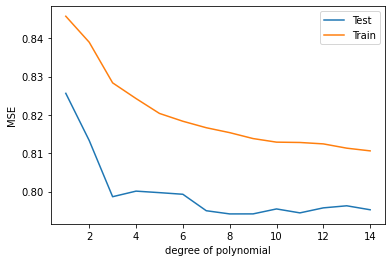

In [88]:
import matplotlib.pyplot as plt
plt.plot(range(1,num_degrees),mse_test,label="Test")
plt.plot(range(1,num_degrees),mse_train,label="Train")
plt.xlabel('degree of polynomial')
plt.ylabel('MSE')
plt.legend()
plt.show()

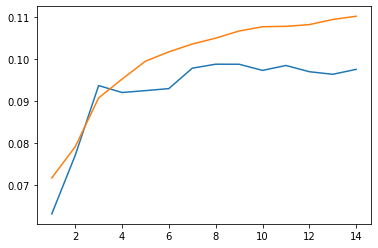

In [89]:
plt.plot(range(1,num_degrees), r2_test)
plt.plot(range(1,num_degrees), r2_train)

# Part b: Bias-variance trade-off and resampling techniques

In [98]:
import pandas as pd

def ols_regression(N, noise_var, deg, n_bootstrap=5,use_test=True):
    x1, y1, x, y, z = create_data(N, noise_var)
    z = z[:, np.newaxis]
    X = create_design_matrix(x.flatten(), y.flatten(), deg)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.10, random_state=0)
    train_data = (X_train, z_train)
    test_data = (X_test, z_test)

    # OLS + bootstrap sampling
    zpred_boots_ols = bootstrap(n_bootstrap, train_data, X_test, ols_model)

    # get statistics of the sampling
    stats = statistics(z_test, zpred_boots_ols, sampling=True)
    #print(stats)

    # display prediction 
    df = pd.DataFrame(zpred_boots_ols)
    return df, stats

# test OLS regression with bootstrap sampling technique
noise_var = 0.0
N = 100
num_degrees = 5
n_bootstrap = 10

df, stats = ols_regression(N, noise_var, num_degrees, n_bootstrap)
print(stats)
df.head()

{'MSE': 0.0019514186835982617, 'R2': 0.7486072742444734, 'EBV': (0.0019514186835982617, 0.0, 0.0019514186835982619)}


,0,1,2,3,4,5,6,7,8,9
0,0.050238,0.049305,0.052255,0.051189,0.048448,0.050563,0.049166,0.048874,0.048455,0.051457
1,0.071017,0.061492,0.066986,0.055013,0.062880,0.058561,0.059889,0.070012,0.075667,0.063346
2,0.205703,0.198988,0.203616,0.193982,0.200045,0.203038,0.199845,0.204239,0.207444,0.197213
3,0.397924,0.392234,0.397695,0.392737,0.391964,0.397273,0.392068,0.394579,0.393393,0.398052
4,0.720965,0.721010,0.720114,0.723427,0.726335,0.721408,0.720661,0.724803,0.725880,0.724213


In [96]:
# determine MSE with varying model complexity
num_degrees = 20

mse_bootstrap = []
for deg in range(1,num_degrees+1):
    _, stats = ols_regression(N=100,noise_var=0.5,deg=deg,n_bootstrap=10)
    mse_bootstrap += [stats['MSE']]

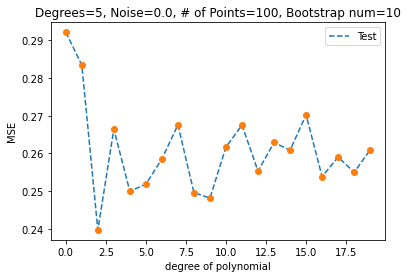

In [100]:
plt.plot(mse_bootstrap,'--',label="Test")
plt.plot(mse_bootstrap,'o')
plt.title(f"Degrees={num_degrees}, Noise={noise_var}, # of Points={N}, Bootstrap num={n_bootstrap}")
plt.ylabel('MSE')
plt.xlabel('degree of polynomial')
plt.legend()

In [82]:
from ipywidgets import interact

def f(noise):
    num_degrees = 20

    mse_bootstrap = []
    for deg in range(1,num_degrees+1):
        _, stats = ols_regression(N=250,noise_var=noise,deg=deg,n_bootstrap=10)
        mse_bootstrap += [stats['MSE']]
    plt.plot(mse_bootstrap,'--',label="Noise="+str(noise))
    plt.plot(mse_bootstrap,'o')
    plt.ylabel('MSE')
    plt.xlabel('degree of polynomial')
    plt.legend()
    
interact(f,noise=(0,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='noise', max=1.0), Output()), _dom_classes=('widget-i…

# Part c: Cross-validation as resampling techniques, adding more complexity

In [101]:
np.random.seed(2021)

deg = 5
N = 100
noise_var = 0.1
num_degrees = 10

x1, y1, x, y, z = create_data(N, noise_var)
z = z[:, np.newaxis]
X = create_design_matrix(x.flatten(), y.flatten(), deg)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20, random_state=0)
train_data = (X_train, z_train)
test_data = (X_test, z_test)

# --------- PART (c) code starts here --------------------
kfold = 10
stat_record = cross_validation(kfold, X, z, ols_model, lmb=1)
print(stat_record.mean(axis=0))

print(stat_record)

MSE    0.020633
R2     0.325424
dtype: float64
        MSE        R2
0  0.061073  0.360926
1  0.012548  0.890711
2  0.015938  0.819737
3  0.015180  0.701967
4  0.013036  0.462980
5  0.011994  0.363244
6  0.012712  0.317115
7  0.011983  0.423147
8  0.010891  0.407565
9  0.040977 -1.493154


In [107]:
np.random.seed(2021)

deg = 10
N = 100
noise_var = 0.1
num_degrees = 5

nlambdas = 20
lambdas = np.logspace(-3, 2, nlambdas)

mse_cv = []
for lmb in lambdas:
    x1, y1, x, y, z = create_data(N, noise_var)
    z = z[:, np.newaxis]
    X = create_design_matrix(x.flatten(), y.flatten(), num_degrees)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20, random_state=0)
    train_data = (X_train, z_train)
    test_data = (X_test, z_test)

    # --------- PART (c) code starts here --------------------
    kfold = 10
    stat_record = cross_validation(kfold, X, z, ols_model, lmb)
    mse_cv += [stat_record.mean(axis=0)[0]]

Text(0.5, 0, '$log_{10}(\\lambda$)')

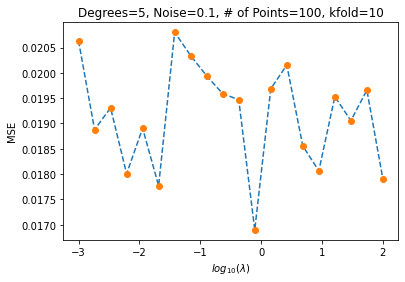

In [108]:
plt.plot(np.log10(lambdas),mse_cv,'--')
plt.plot(np.log10(lambdas),mse_cv,'o')
plt.title(f"Degrees={num_degrees}, Noise={noise_var}, # of Points={N}, kfold={kfold}")
plt.ylabel('MSE')
plt.xlabel('$log_{10}(\lambda$)')

# Part d: Ridge regression on the Franke function with resampling

{'MSE': 0.7933865331778989, 'R2': 0.09323200275822252, 'EBV': (0.7933865331778989, 0.0, 0.7933865331778989)}


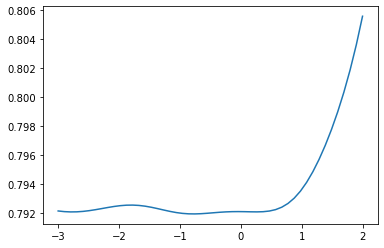

In [138]:
np.random.seed(2021)

deg = 5
N = 100
noise_var = 0.9
num_degrees = 10

x1, y1, x, y, z = create_data(N, noise_var)
z = z[:, np.newaxis]
X = create_design_matrix(x.flatten(), y.flatten(), deg)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)
train_data = (X_train, z_train)
test_data = (X_test, z_test)

# Ridge regression
zpred_ridge, beta_ridge = ridge_model(train_data, X_test, lmb=0)
stats = statistics(z_test, zpred_ridge, sampling=True)
print(stats)


# Vary lambda values 
nlambdas = 50
lambdas = np.logspace(-3, 2, nlambdas)

mse_ridge = []
r2_ridge = []
for lmb in lambdas:
    zpred_ridge, beta_ridge = ridge_model(train_data, X_test, lmb)
    stats = statistics(z_test, zpred_ridge, sampling=True)
    mse_ridge +=[stats['MSE']]
    r2_ridge += [stats['R2']]
    
    #print(stats)
    
plt.plot(np.log10(lambdas),mse_ridge)


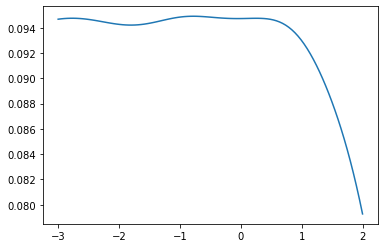

In [136]:
plt.plot(np.log10(lambdas),r2_ridge)

## ridge + bootstrap

In [116]:
n_bootstrap = 5
zpred_boots_ridge = bootstrap(n_bootstrap, train_data, X_test, ridge_model)
stats = statistics(z_test, zpred_boots_ridge, sampling=True)
print(stats)
df = pd.DataFrame(zpred_boots_ridge)
print(df.head())

{'MSE': 0.011957422101714585, 'R2': 0.324965259664204, 'EBV': (0.011957422101714585, 0.0, 0.011957422101714587)}
          0         1         2         3         4
0  0.047239  0.054539  0.043825  0.039309  0.049792
1  0.018307  0.016749  0.037826  0.044971  0.043699
2  0.190430  0.190767  0.203026  0.208654  0.218504
3  0.392352  0.381386  0.393374  0.383228  0.386301
4  0.716509  0.718217  0.725107  0.723320  0.722002


## ridge + cross-validation

In [120]:
# Ridge regression + cross-validation sampling
kfold = 6
stat_record = cross_validation(kfold, X, z, ridge_model, lmb=5)
mse_ = np.mean(stat_record)[0]
r2_ =  np.mean(stat_record)[1]
print(f'MSE={mse_}, R2={r2_}')

stat_record

MSE=0.03748942197398736, R2=0.11433091538234741


,MSE,R2
0,0.092124,0.144163
1,0.049873,0.435408
2,0.023296,0.332413
3,0.020420,-0.020469
4,0.013281,0.341279
5,0.025942,-0.546809


# Part e: Lasso Regression on the Franke function with resampling

## w/o sampling

In [156]:
# Vary lambda values 
np.random.seed(2021)

N = 100 
noise_var = 0.1 
deg = 5

x1, y1, x, y, z = create_data(N, noise_var)
z = z[:, np.newaxis]
X = create_design_matrix(x.flatten(), y.flatten(), deg)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)
train_data = (X_train, z_train)
test_data = (X_test, z_test)


nlambdas = 10
lambdas = np.logspace(-3, 3, nlambdas)

mse_lasso = []

for lmb in lambdas: 
    zpredict_lasso,_ = lasso_model_skl(train_data, X_test, lmb=0.001)
    stats = statistics(z_test,zpredict_lasso)
    print(stats)

{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}
{'MSE': 310.54704791809206, 'R2': -3296.405640251625}


In [158]:
# Lasso regression + bootstrap sampling
zpred_boots_lasso = bootstrap(n_bootstrap, train_data, X_test, lasso_model_skl, lmb=0.001)
stats = statistics(z_test, zpred_boots_lasso, sampling=True)
print(stats)
df = pd.DataFrame(zpred_boots_lasso)
print(df.head())

{'MSE': 0.02496856578452987, 'R2': -0.3255880260149464, 'EBV': (0.02496856578452987, 0.0, 0.024968565784529866)}
          0         1         2         3         4
0  0.497122  0.491865  0.491883  0.499545  0.493271
1  0.319230  0.312932  0.314587  0.320460  0.314032
2  0.063496  0.048471  0.065269  0.052961  0.055405
3  0.177962  0.184549  0.175961  0.185215  0.178918
4  0.777179  0.765006  0.778957  0.785085  0.774081


In [160]:
# Lasso regression + cross-validation sampling
kfold = 6
stat_record = cross_validation(kfold, X, z, lasso_model_skl, lmb=0.001)
mse_ = np.mean(stat_record)[0]
r2_ =  np.mean(stat_record)[1]
print(f'MSE={mse_}, R2={r2_}')

stat_record

MSE=163.79130280673567, R2=-4166.384803155521


,MSE,R2
0,333.215530,-3094.598043
1,245.284882,-2775.752330
2,116.470314,-3336.621588
3,77.574454,-3875.763026
4,61.411922,-3044.854577
5,148.790715,-8870.719255
